In [1]:
# ============================================================
# Notebook setup
# ============================================================

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import nab
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared, DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error

# Load data
data_folder = 'data/nab'

file_name1 = 'realTweets/Twitter_volume_AMZN.csv'
data, labels, windows = nab.load_series(file_name1, data_folder)

# Filling Missing Values with Gaussian Processes

## Back to our Benchmark Series

**Let's see how to use Gaussian Processes to fill missing values**

Before artificially introducing gaps, our benchmark series looks as follows

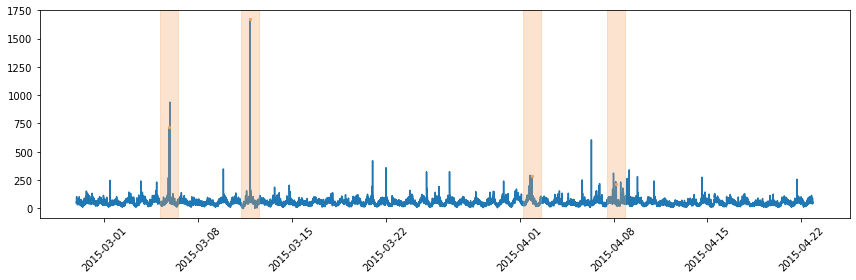

In [2]:
nab.plot_series(data, labels, windows)

* There is (at least) a _period_ and _noise_, but _no trend_. The mean is not zero

## Detecting the Period

**We may try to _detect the periods_ by looking at the FFT**

Finding the _approximate_ values is enough (training will do the rest)

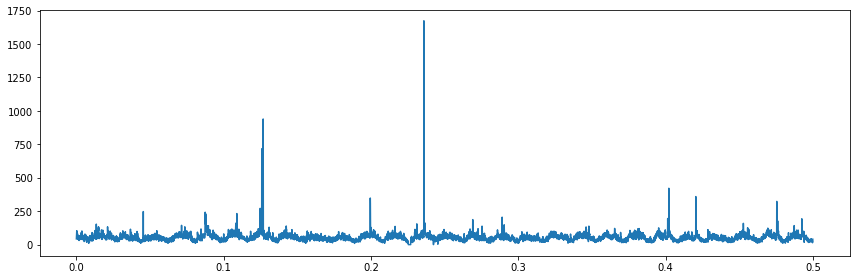

In [3]:
f, y = nab.plot_fft_abs(data)

* There are a coupe of very pronounced peaks

## Detecting the Period

**Let us see to which periods to they correspond**

* We select the main frequencies and invert them to obtain periods
* ...Then round them and take the unique values
* ...So as to simplify the identification of clusters

In [4]:
main_periods = 1/f[y >= 500]
main_periods = np.unique(np.round(main_periods))
print(main_periods)

[4. 8.]


**Periods are multiples one of each other**

* The longest is 8 * 5 minutes = 40 minutes

## Detecting the Period

**Let us try also with an autocorrelation plot:**

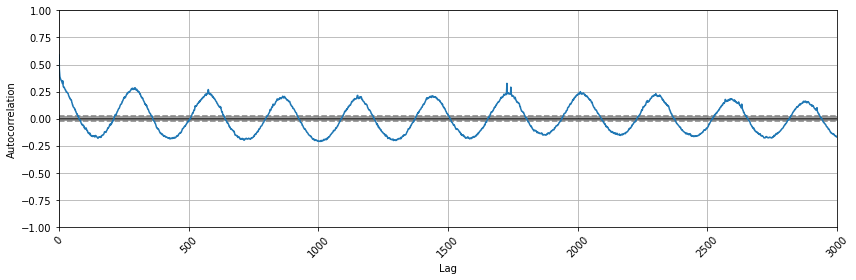

In [5]:
nab.plot_autocorrelation(data, max_lag=3000)

* The period seems _much longer_ here!

## Multiple Frequencies

**Why the mismatch?**

* The signal has both _high frequency_ and _low frequency_ components
* ...But is mostly dominated by the high frequency component

**We will try to focus on the low frequency component**

To achieve that we need to _filter out_ the higher frequencies

* This can be done via any kind of [low-pass filter](https://en.wikipedia.org/wiki/Low-pass_filter)
* I.e. a transformation that _reduces_ the amplitude of _high-frequency_ components
* ...And keeps the _low-frequency_ ones mostly _unaltered_


## Low-Pass Filter

**An ideal low pass filter has the following input-output curve**

...In _frequency space_ (i.e. Fourier Transform space)

<center><img src="assets/700px-Butterworth_response.svg.png" width="500px"/></center>

* After a cutoff point ($1/\tau$), the Fourier amplitudes are strongly reduced
* Image courtesy of Wikipedia

## Low-Pass Filter

**A simple low-pass filter: the _Exponentially Weighted Moving Average_**

This is a form of discrete (non-ideal) filter, given by the recursion:

$$
s_i = \left\{\begin{aligned}
& x_i & \text{ if } i = 1 \\
& \alpha x_i + (1 - \alpha) s_{i-1} & \text{ otherwise}
\end{aligned}\right.
$$

* $s_i$ is the $i$-th element of the output (smoothed) series
* $\alpha$ is called the _smoothing factor_ and is equal to $1 / (1 + \tau)$

**In pandas, we can use the `ewm` iterator, plus the `mean` aggregation function**

```python
DataFrame.ewm(com=None, ...).mean()
```

* The `com` parameter corresponds to $\tau$
* There are many other parameters that can be [checked on the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html)

## Focusing on the Lower Frequencies

**Let's apply the EWMA and plot the smoothed series**

We will start with $\tau = 8$ (the bare minimum in our case)

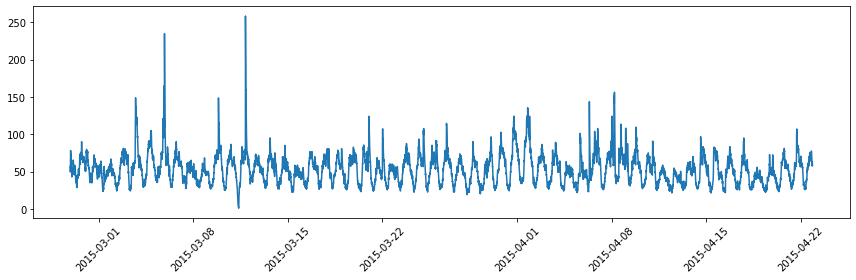

In [6]:
data_s = data.ewm(com=8).mean()
nab.plot_series(data_s)

## Focusing on the Lower Frequencies

**We can now apply the FFT to the smoothed signal**

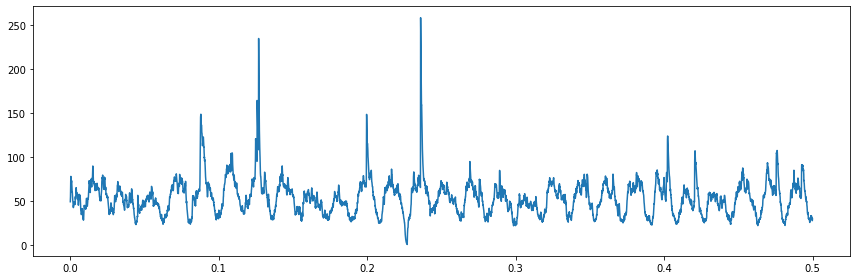

In [7]:
f, y = nab.plot_fft_abs(data_s)

* The low frequency components are _still too high_

## Focusing on the Lower Frequencies

**Let's increase $\tau$ decrease the cutoff frequency (and plot again the FFT)**

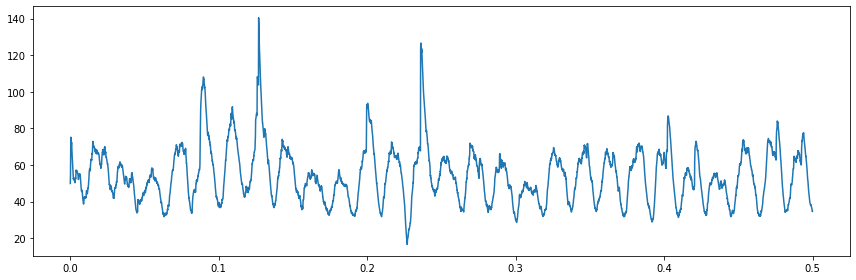

In [8]:
data_s = data.ewm(com=32).mean()
f, y = nab.plot_fft_abs(data_s)

* The long period from the autocorrelation plot is still not visible

## Focusing on the Lower Frequencies

**Let's decrease _even more_ the cutoff frequency (and plot again the FFT)**

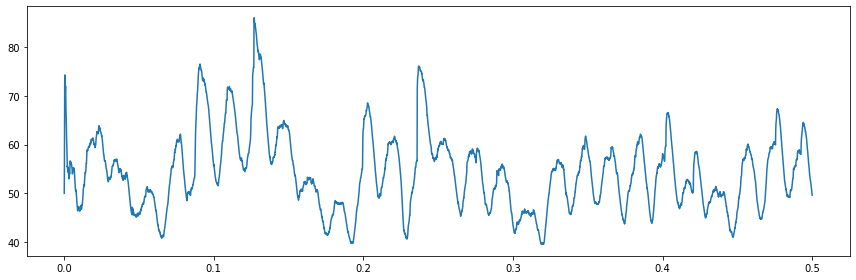

In [9]:
data_s = data.ewm(com=128).mean()
f, y = nab.plot_fft_abs(data_s)

* The _sharp peak in the left-most part_ of the FFT plot is probably what we are looking for

## Detecting the Low-Frequency Period

**Let's detect the main frequencies and translate them to periods (again)**

In [10]:
main_periods = 1/f[y >= 70]
main_periods[:4] # focus on the left-most section of the FFT

array([2638.5       , 2261.57142857, 1978.875     , 1759.        ])

The peak appears to be between 1800 and 2600 steps

* This information is _probably enough_ to train a Gaussian Process
* ...But let's try to understand something more

**This series comes from human activities**

So, let's consider a few likely periods:

* Daily: $24 \times 60 / 5 = 288$ steps per day $\Rightarrow$ this is not the one
* Weekly: $7 \times 24 \times 60 / 5 = 2016$ steps per week $\Rightarrow$ this is our period!

## Adding Time Values

**We now need to add time information to our dataframe:**

* Unfortunately, Gaussian Processes from scikit-learn cannot handle `datetime` objects
* ...So we need to turn time into a number

We will take an _easy approach_: one time step = 1 unit of time

In [11]:
data_t = data.copy()
data_t['time'] = np.arange(len(data))
data_t.head()

,value,time
timestamp,,
2015-02-26 21:42:53,57,0
2015-02-26 21:47:53,43,1
2015-02-26 21:52:53,55,2
2015-02-26 21:57:53,64,3
2015-02-26 22:02:53,93,4


## Selected Data Segment

**We will focus on a small portion of the series**

* Mostly, we do it to keep the training time low
* ...But it may make sense also in practice (e.g. capture local patterns)

In [12]:
segment = data_t[:len(data_t)//30]

Let's look at the length of the considered sub-series:

In [13]:
print(f'Our segment contains {len(segment)} time steps')

Our segment contains 527 time steps


* Not enough points to span a full week
* This will make our weekly period a bit less effective

## Artificial Data Removal

**Now we can artificially remove values**

We will just assume that half the data points are missing

In [14]:
np.random.seed(42)
idx = np.arange(len(segment))
np.random.shuffle(idx[1:-1]) # keep first and last in their positionn

idx[1], idx[-1] = idx[-1], idx[1] # move last element in the first half

trdata = segment.iloc[idx[:len(idx)//2]]
tsdata = segment.iloc[idx[len(idx)//2:]]

* We made sure that the _start and end_ of the series are not missing
* This is needed for the basic interpolation methods to work
* ...Since we will use them as our baseline

**Our main goal will be _learning how to choose a kernel_ for a real-world series**

## Learning a Gaussian Process

**Now we need to choose a kernel**

Let us start with some noise, plus a local correlation:

In [15]:
kernel = WhiteKernel(1e-3, (1e-4, 1e-1))
kernel += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-2, 1e2))

Then we can train a model and obtain the predictions:

In [16]:
np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(trdata[['time']], trdata['value']) # needs 2D input
print(gp.kernel_)

times = np.arange(len(segment)).reshape(-1,1)
pred, std = gp.predict(times, return_std=True)
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

WhiteKernel(noise_level=0.1) + 10**2 * RBF(length_scale=1.16)


/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


## Learning a Gaussian Process

**Let's have a look at the predictions:**

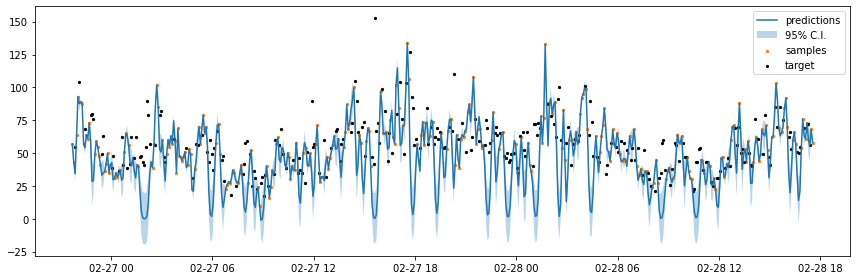

In [17]:
nab.plot_gp(target_samples=tsdata['value'], samples=trdata['value'], pred=pred, std=std)

In [18]:
rmse = np.sqrt(mean_squared_error(segment['value'], pred))
print(f'RMSE for the Gaussian Process: {rmse}')

RMSE for the Gaussian Process: 22.679668649605198


## Baseline

**Let's see the performance of the simpler approaches**

In [19]:
args = [{'method':'ffill'}, {'method':'bfill'}, {'method':'linear'},
        {'method':'nearest'}, {'method':'polynomial', 'order': 2}]

segment_holes = segment.copy()
segment_holes.loc[tsdata.index, 'value'] = np.NaN
for a in args:
    tmp = segment_holes['value'].interpolate(**a)
    rmse = np.sqrt(mean_squared_error(segment['value'], tmp))
    print(f'RMSE for {a["method"]}: {rmse:.2f}')

RMSE for ffill: 13.49
RMSE for bfill: 13.53
RMSE for linear: 10.92
RMSE for nearest: 12.78
RMSE for polynomial: 14.11


We are _beaten by all approaches_! ...But we still need to refine our kernel :-)
* ...And don't forget that the MSE is not necessarily the best metric

## Learning to Learn a Gaussian Process

**Let's look again at the predictions:**

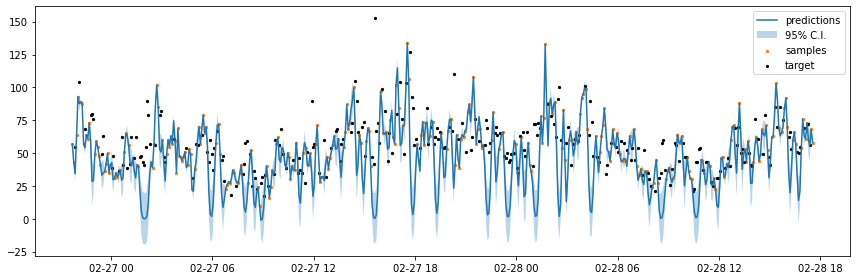

In [20]:
nab.plot_gp(target_samples=tsdata['value'], samples=trdata['value'], pred=pred, std=std)

* The model has _a tendency to predict the value zero_
* ...And in fact, by default the GP has zero-mean!

## Learning to Learn a Gaussian Process

**We need a way to _modify the mean_ of our process**

* A simple `ConstantKernel` will make _all points correlated_
* ...Effectively making the mean match the _mean of the training set_

In [21]:
kernel = WhiteKernel(1e-3, (1e-4, 5e-2))
kernel += ConstantKernel(1, (1e-2, 1e2))
kernel += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-2, 1e2))

Let's train the model again:

In [22]:
np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(trdata[['time']], trdata['value']) # needs 2D input
print(gp.kernel_) 
times = np.arange(len(segment)).reshape(-1,1)
pred, std = gp.predict(times, return_std=True) 
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

WhiteKernel(noise_level=0.05) + 10**2 + 10**2 * RBF(length_scale=0.01)


/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__noise_level is close to the specified upper bound 0.05. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found fo

## Learning to Learn a Gaussian Process

**The new predictions are much better!**

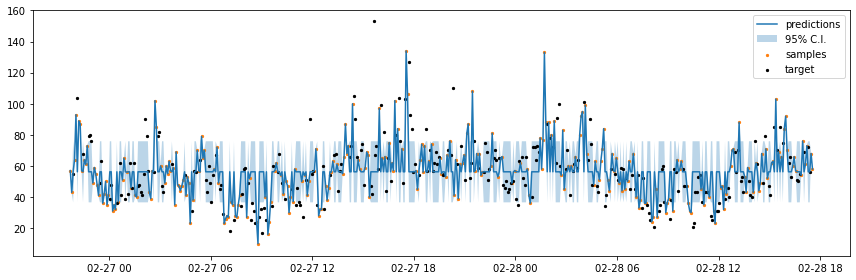

In [23]:
nab.plot_gp(target_samples=tsdata['value'], samples=trdata['value'], pred=pred, std=std)

In [24]:
rmse = np.sqrt(mean_squared_error(segment['value'], pred))
print(f'RMSE for the Gaussian Process: {rmse}')

RMSE for the Gaussian Process: 13.62058586682199


## Learning to Learn a Gaussian Process

**We are using a very smooth kernel, but our signal _is not smooth_**

...So we will employ _a kernel for less smooth processes_, i.e. the [Matern kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html):

In [25]:
from sklearn.gaussian_process.kernels import Matern
kernel = WhiteKernel(1e-3, (1e-4, 1e-1))
kernel += ConstantKernel(1, (1e-2, 1e2))
kernel += ConstantKernel(1, (1e-2, 1e2)) * Matern(1, (1e-2, 1e2), nu=0.55)

* The lower the `nu` parameter the less smooth the prediction (it must hold $\nu > 0.5$)

In [26]:
np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(trdata[['time']], trdata['value']) # needs 2D input
print(gp.kernel_)
times = np.arange(len(segment)).reshape(-1,1)
pred, std = gp.predict(times, return_std=True)
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

WhiteKernel(noise_level=0.1) + 10**2 + 10**2 * Matern(length_scale=1.53, nu=0.55)


/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for

## Learning to Learn a Gaussian Process

**The new predictions already beat all baseline approaches**

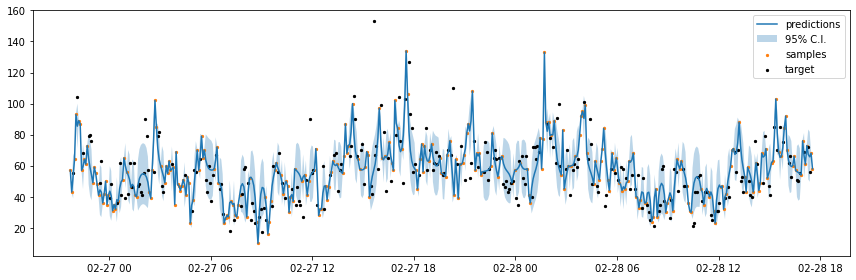

In [27]:
nab.plot_gp(target_samples=tsdata['value'], samples=trdata['value'], pred=pred, std=std)

In [28]:
rmse = np.sqrt(mean_squared_error(segment['value'], pred))
print(f'RMSE for the Gaussian Process: {rmse}')

RMSE for the Gaussian Process: 10.685415693410349


## Learning to Learn a Gaussian Process

**We are still not exploiting the (multiple) _periods_!**

...So let's add kernels to capture them and repeat training:

In [29]:
kernel = WhiteKernel(1e-3, (1e-4, 1e-1))
kernel += ConstantKernel(1, (1e-2, 1e2))
kernel += ConstantKernel(1, (1e-2, 1e2)) * Matern(1, (1e-2, 1e2), nu=0.55)
kernel += ConstantKernel(1, (1e-2, 1e2)) * ExpSineSquared(1, 8, (1e-2, 1e2), (4, 12))
kernel += ConstantKernel(1, (1e-2, 1e2)) * ExpSineSquared(1, 2016, (1e-2, 1e2), (1900, 2100))

np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(trdata[['time']], trdata['value']) # needs 2D input
print(gp.kernel_)

times = np.arange(len(segment)).reshape(-1,1)
pred, std = gp.predict(times, return_std=True)
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

WhiteKernel(noise_level=0.000119) + 10**2 + 10**2 * Matern(length_scale=0.0725, nu=0.55) + 7.81**2 * ExpSineSquared(length_scale=0.01, periodicity=4.01) + 10**2 * ExpSineSquared(length_scale=0.0157, periodicity=2.1e+03)


/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The o

## Learning a Gaussian Process

**And we have gained yet something more**

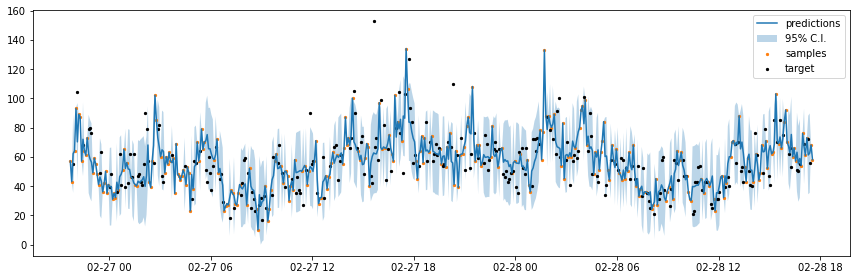

In [30]:
nab.plot_gp(target_samples=tsdata['value'], samples=trdata['value'], pred=pred, std=std) 

In [31]:
rmse = np.sqrt(mean_squared_error(segment['value'], pred))
print(f'RMSE for the Gaussian Process: {rmse}')

RMSE for the Gaussian Process: 10.661170185529931


## Learning a Gaussian Process

**And we have gained yet something more**

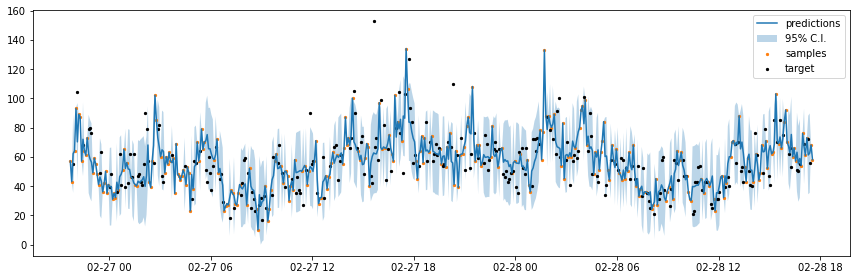

In [32]:
nab.plot_gp(target_samples=tsdata['value'], samples=trdata['value'], pred=pred, std=std)

* Much more, in fact, since we also have _confidence intervals_!

## Considerations

**Gaussian Processes can be effective for filling missing values**

* We take advantage of their good performance at interpolation
* We get access to confidence intervals

**Still, they require some care**

* Naive setups are likely to fail
* Exploiting domain knowledge may help considerably

**Use them only if you think it may be worth it:**

* How many missing values? How large are the gaps?

**Approximate analysis is enough to choose a kernel**

* E.g. we do not need the "true" frequencies: their order of magnitude is enough
* The training algorithm will handle the rest
